In [3]:
import tensorflow as tf

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.chdir('/content/drive/My Drive/AIML/GreatLearning/Capstone/')

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras

from nltk.tokenize import word_tokenize,sent_tokenize

from keras.models import Sequential
from keras.preprocessing import text, sequence
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU, Flatten, Input, LeakyReLU, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.preprocessing import LabelEncoder


In [7]:
df = pd.read_csv('week1_data.csv')  # read the data
df.head()

,Assignment group,ProcessedDescription
0,GRP_0,login issue verify user detail employee manage...
1,GRP_0,outlook team meeting skype meeting etc not app...
2,GRP_0,not log vpn not log vpn best
3,GRP_0,unable access tool page unable access tool page
4,GRP_0,skype error skype error


In [8]:
df[pd.isnull(df).any(axis=1)]

,Assignment group,ProcessedDescription
1556,GRP_0,NaN
2423,GRP_34,NaN


In [9]:
df.dropna(subset = ["ProcessedDescription"], inplace=True)

In [10]:
df.isna().sum() 

Assignment group        0
ProcessedDescription    0
dtype: int64

In [11]:
df.ProcessedDescription.apply(lambda x: len(x.split(" "))).mean()

23.47769489542197

In [12]:
words = []
for i in df.ProcessedDescription.values:
    words.append(i.split())
words[:1]

[['login',
  'issue',
  'verify',
  'user',
  'detail',
  'employee',
  'manager',
  'name',
  'check',
  'user',
  'name',
  'ad',
  'reset',
  'password',
  'advise',
  'user',
  'login',
  'check',
  'caller',
  'confirm',
  'able',
  'login',
  'issue',
  'resolve']]

In [13]:
tokenizer = text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)

In [14]:
X = sequence.pad_sequences(tokenized_train, maxlen = 25)

In [15]:
tokenizer.word_index

{'not': 1,
 'please': 2,
 'password': 3,
 'yes': 4,
 'erp': 5,
 'tool': 6,
 'user': 7,
 'na': 8,
 'company': 9,
 'access': 10,
 'issue': 11,
 'work': 12,
 'unable': 13,
 'reset': 14,
 'error': 15,
 'email': 16,
 'need': 17,
 'sid': 18,
 'ticket': 19,
 'account': 20,
 'hostname': 21,
 'outlook': 22,
 'site': 23,
 'system': 24,
 'get': 25,
 'help': 26,
 'job': 27,
 'network': 28,
 'circuit': 29,
 'power': 30,
 'name': 31,
 'login': 32,
 'message': 33,
 'change': 34,
 'use': 35,
 'problem': 36,
 'vendor': 37,
 'server': 38,
 'new': 39,
 'printer': 40,
 'open': 41,
 'see': 42,
 'connect': 43,
 'log': 44,
 'backup': 45,
 'phone': 46,
 'time': 47,
 'event': 48,
 'crm': 49,
 'start': 50,
 'engineering': 51,
 'usa': 52,
 'call': 53,
 'check': 54,
 'telecom': 55,
 'order': 56,
 'request': 57,
 'able': 58,
 'vpn': 59,
 'report': 60,
 'team': 61,
 'update': 62,
 'outage': 63,
 'number': 64,
 'type': 65,
 'send': 66,
 'customer': 67,
 'skype': 68,
 'device': 69,
 'try': 70,
 'print': 71,
 'contact

In [16]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

10162


In [17]:
group_frequency = dict(df['Assignment group'].value_counts())

In [18]:
group_df = pd.DataFrame.from_dict(group_frequency, orient='index', columns=['frequency'])
group_df['percent representation'] = group_df['frequency'] / group_df['frequency'].sum()
group_df['cumulative percentage'] = group_df['percent representation'].cumsum(axis = 0)
group_df.head(15)

,frequency,percent representation,cumulative percentage
GRP_0,3199,0.467895,0.467895
GRP_8,313,0.045780,0.513676
GRP_24,277,0.040515,0.554190
GRP_12,243,0.035542,0.589732
GRP_2,238,0.034811,0.624543
GRP_19,212,0.031008,0.655551
GRP_3,198,0.028960,0.684511
GRP_13,141,0.020623,0.705134
GRP_25,116,0.016967,0.722100
GRP_14,116,0.016967,0.739067


In [19]:
groups = df.groupby(['Assignment group'])
misc_group=[]
for grp in df['Assignment group'].unique():
      if(groups.get_group(grp).shape[0]<100):
        misc_group.append(grp)
print('GRP_74 which have under 100 samples are {} '.format(len(misc_group)))
df['Assignment group - After']=df['Assignment group'].apply(lambda x : 'GRP_74' if x in misc_group else x)

GRP_74 which have under 100 samples are 63 


In [20]:
df['Assignment group - After'].value_counts().sort_values(ascending=False).index

Index(['GRP_0', 'GRP_74', 'GRP_8', 'GRP_24', 'GRP_12', 'GRP_2', 'GRP_19',
       'GRP_3', 'GRP_13', 'GRP_25', 'GRP_14', 'GRP_33'],
      dtype='object')

In [21]:
df['Assignment group - After'].value_counts()

GRP_0     3199
GRP_74    1677
GRP_8      313
GRP_24     277
GRP_12     243
GRP_2      238
GRP_19     212
GRP_3      198
GRP_13     141
GRP_14     116
GRP_25     116
GRP_33     107
Name: Assignment group - After, dtype: int64

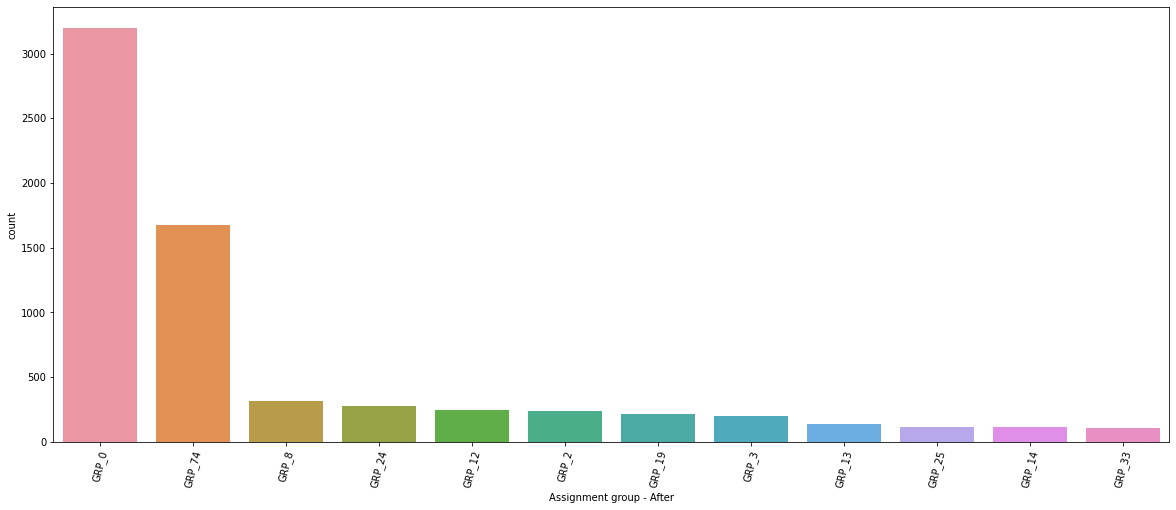

In [22]:
df_desc = df['Assignment group - After'].value_counts().sort_values(ascending=False).index
plt.figure(figsize= (20,8))
plt.xticks(rotation=75)
sns.countplot(x='Assignment group - After', data=df, order=df_desc)

In [23]:
df.head()

,Assignment group,ProcessedDescription,Assignment group - After
0,GRP_0,login issue verify user detail employee manage...,GRP_0
1,GRP_0,outlook team meeting skype meeting etc not app...,GRP_0
2,GRP_0,not log vpn not log vpn best,GRP_0
3,GRP_0,unable access tool page unable access tool page,GRP_0
4,GRP_0,skype error skype error,GRP_0


In [30]:
encoder = LabelEncoder()
Y = df['Assignment group - After']
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = to_categorical(encoded_Y)

In [31]:
from sklearn import model_selection
X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(X, dummy_y, test_size=0.25, random_state=42)

In [32]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42)

In [33]:
print("Size of the training dataframe is ",len(X_train))
print("Size of the Validation dataframe is ",len(X_val))
print("Size of the test dataframe is ",len(X_test))
print("{0:0.2f}% data is in training set".format((len(X_train)/len(df.index)) * 100))
print("{0:0.2f}% data is in training set".format((len(X_val)/len(df.index)) * 100))
print("{0:0.2f}% data is in test set".format((len(X_test)/len(df.index)) * 100))

Size of the training dataframe is  3588
Size of the Validation dataframe is  1539
Size of the test dataframe is  1710
52.48% data is in training set
22.51% data is in training set
25.01% data is in test set


## Model 1:: Bi-directional LSTM

In [310]:
# define the model
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=300, input_length=25, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.4 , dropout = 0.5)))
model.add(Dense(12, activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.05), loss='categorical_crossentropy', metrics=['acc'])

# summarize the model
print(model.summary())

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_46 (Embedding)     (None, 25, 300)           3048600   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_165 (Dense)            (None, 12)                3084      
Total params: 3,490,980
Trainable params: 3,490,980
Non-trainable params: 0
_________________________________________________________________
None


In [304]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [311]:
# fit the model
model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=10, batch_size=32)
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Epoch 1/10
113/113 [==============================] - 24s 210ms/step - loss: 1.8660 - acc: 0.4836 - val_loss: 1.6266 - val_acc: 0.5068
Epoch 2/10
113/113 [==============================] - 23s 200ms/step - loss: 1.6408 - acc: 0.5178 - val_loss: 1.9043 - val_acc: 0.5146
Epoch 3/10
113/113 [==============================] - 23s 201ms/step - loss: 1.8225 - acc: 0.4994 - val_loss: 2.0521 - val_acc: 0.4977
Epoch 4/10
113/113 [==============================] - 23s 201ms/step - loss: 1.8834 - acc: 0.4891 - val_loss: 1.9948 - val_acc: 0.5094
Epoch 5/10
113/113 [==============================] - 23s 200ms/step - loss: 1.9064 - acc: 0.4964 - val_loss: 2.0567 - val_acc: 0.4782
Epoch 6/10
113/113 [==============================] - 23s 200ms/step - loss: 1.8986 - acc: 0.5039 - val_loss: 1.9519 - val_acc: 0.4893
Epoch 7/10
113/113 [==============================] - 23s 200ms/step - loss: 1.8740 - acc: 0.4978 - val_loss: 2.0743 - val_acc: 0.5146
Epoch 8/10
113/113 [==============================] - 2

- The final loss of train and validation data is 186.86% and 195.46% respectively
- The final test accuracy is 52.10% which is not very good

## Model 2:: LSTM with 2 Dense layers

In [42]:
embed_dim = 128
lstm_out = 196

lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, embed_dim,input_length = X.shape[1]))
lstm_model.add(SpatialDropout1D(0.4))
lstm_model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(12, activation='softmax'))
lstm_model.compile(loss = 'categorical_crossentropy', optimizer=keras.optimizers.Adam(lr = 0.01),metrics = ['accuracy'])
print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 25, 128)           1300736   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 25, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 64)                12608     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                780       
Total params: 1,568,924
Trainable params: 1,568,924
Non-trainable params: 0
____________________________________________

In [325]:
# fit the model
lstm_model.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=32)
# evaluate the model
loss, accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Epoch 1/10
79/79 [==============================] - 10s 131ms/step - loss: 1.6240 - accuracy: 0.5026 - val_loss: 1.3977 - val_accuracy: 0.5664
Epoch 2/10
79/79 [==============================] - 10s 127ms/step - loss: 1.1909 - accuracy: 0.6280 - val_loss: 1.3603 - val_accuracy: 0.6110
Epoch 3/10
79/79 [==============================] - 10s 129ms/step - loss: 0.8919 - accuracy: 0.7260 - val_loss: 1.5521 - val_accuracy: 0.5645
Epoch 4/10
79/79 [==============================] - 10s 127ms/step - loss: 0.6886 - accuracy: 0.7838 - val_loss: 1.4524 - val_accuracy: 0.5970
Epoch 5/10
79/79 [==============================] - 10s 128ms/step - loss: 0.5483 - accuracy: 0.8280 - val_loss: 1.5815 - val_accuracy: 0.5998
Epoch 6/10
79/79 [==============================] - 10s 127ms/step - loss: 0.4569 - accuracy: 0.8570 - val_loss: 1.7385 - val_accuracy: 0.6128
Epoch 7/10
79/79 [==============================] - 12s 151ms/step - loss: 0.3645 - accuracy: 0.8865 - val_loss: 1.9659 - val_accuracy: 0.6091

- Simple LSTM model shows improvement in final test accuracy = 60.46%
- The model seems to have over-fitted as train accuracy has reached 93.03% and loss has reduced to 23.23%
- The validation accuracy is also comparitively low = 61.10% and loss has jumped upto 253.53%
- The validation accuracy does not seem to increase in the 10 epochs

#### Hyperparameter tuning for LSTM model

In [ ]:
lstm_model_4 = Sequential()
lstm_model_4.add(Embedding(vocab_size, output_dim=200, input_length=25, trainable=True))
lstm_model_4.add(Dropout(0.5))
lstm_model_4.add(LSTM(128, recurrent_dropout = 0.5 , dropout = 0.5))
lstm_model_4.add(Dense(64, activity_regularizer=l1(0.01)))
lstm_model_4.add(LeakyReLU(alpha=0.3))
lstm_model_4.add(Dropout(0.5))
lstm_model_4.add(Dense(12, activity_regularizer=l1(0.01),activation='softmax'))
lstm_model_4.compile(loss = 'categorical_crossentropy', optimizer=adam_optimizer,metrics = ['accuracy'])
print(lstm_model_4.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 25, 200)           2032400   
_________________________________________________________________
dropout_10 (Dropout)         (None, 25, 200)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               168448    
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 12)              

In [ ]:
adam_optimizer = Adam(lr=1e-2, beta_1=0.09, beta_2=0.999, amsgrad=True)

lstm_model_4.compile(loss='categorical_crossentropy',
              optimizer=adam_optimizer,
              metrics='accuracy')

In [ ]:
BATCH_SIZE = 32
EPOCHS = 20
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

history = lstm_model_4.fit(X_train_val, y_train_val, validation_split=0.5, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, shuffle=True, callbacks=[stop, reduce_lr])

Epoch 1/20
81/81 [==============================] - 9s 109ms/step - loss: 1.7935 - accuracy: 0.5205 - val_loss: 4.9285 - val_accuracy: 0.1026
Epoch 2/20
81/81 [==============================] - 9s 106ms/step - loss: 1.4216 - accuracy: 0.6243 - val_loss: 1.4928 - val_accuracy: 0.6112
Epoch 3/20
81/81 [==============================] - 8s 105ms/step - loss: 1.0856 - accuracy: 0.7401 - val_loss: 1.5457 - val_accuracy: 0.6127
Epoch 4/20
81/81 [==============================] - 9s 105ms/step - loss: 0.9192 - accuracy: 0.7827 - val_loss: 1.5986 - val_accuracy: 0.6022
Epoch 5/20
81/81 [==============================] - 9s 105ms/step - loss: 0.7937 - accuracy: 0.8357 - val_loss: 2.1976 - val_accuracy: 0.5885
Epoch 6/20
81/81 [==============================] - 9s 106ms/step - loss: 0.7836 - accuracy: 0.8365 - val_loss: 1.8982 - val_accuracy: 0.6022
Epoch 7/20
81/81 [==============================] - 9s 106ms/step - loss: 0.7291 - accuracy: 0.8451 - val_loss: 2.1652 - val_accuracy: 0.5819
Epoch 

In [ ]:
loss, accuracy = lstm_model_4.evaluate(X_test, y_test)
print('Accuracy: %f' % (accuracy*100))
print('loss: %f' % (loss))

54/54 [==============================] - 0s 8ms/step - loss: 2.3069 - accuracy: 0.6333
Accuracy: 63.333333
loss: 2.306902


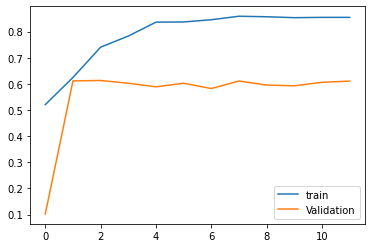

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='Validation')
pyplot.legend()
pyplot.show()

## Model 3:: Loading pre-defined Embedding weights

In [37]:
EMBEDDING_FILE_200 = './glove.6B.200d.txt'

In [35]:
def define_embedding(EMBEDDING_FILE, size):
  embeddings = {}
  for o in open(EMBEDDING_FILE):
      word = o.split(" ")[0]
      # print(word)
      embd = o.split(" ")[1:]
      embd = np.asarray(embd, dtype='float32')
      # print(embd)
      embeddings[word] = embd

  # create a weight matrix for words in training docs
  embedding_matrix = np.zeros((vocab_size, size))

  for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [331]:
embedding_matrix = define_embedding(EMBEDDING_FILE_200, 200)

In [43]:
embedding_size = 200
lstm_out = 196

lstm_model_1 = Sequential()
lstm_model_1.add(Embedding(vocab_size, output_dim=embedding_size, weights=[embedding_matrix], input_length=200, trainable=True))
lstm_model_1.add(SpatialDropout1D(0.4))
lstm_model_1.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
lstm_model_1.add(Dense(12,activation='softmax'))
lstm_model_1.compile(loss = 'categorical_crossentropy', optimizer=keras.optimizers.Adam(lr = 0.01),metrics = ['accuracy'])
print(lstm_model_1.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 200)          2032400   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 200)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               311248    
_________________________________________________________________
dense_2 (Dense)              (None, 12)                2364      
Total params: 2,346,012
Trainable params: 2,346,012
Non-trainable params: 0
_________________________________________________________________
None


In [333]:
# fit the model
lstm_model_1.fit(X_train, y_train, validation_data = (X_val,y_val), epochs=10, batch_size=32)
# evaluate the model
lstm_loss_1, lstm_accuracy_1 = lstm_model_1.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % (lstm_accuracy_1*100))
print('loss: %f' % (lstm_loss_1*100))

Epoch 1/10
113/113 [==============================] - 17s 148ms/step - loss: 1.4743 - accuracy: 0.5465 - val_loss: 1.2739 - val_accuracy: 0.6225
Epoch 2/10
113/113 [==============================] - 16s 145ms/step - loss: 0.9766 - accuracy: 0.7001 - val_loss: 1.2155 - val_accuracy: 0.6303
Epoch 3/10
113/113 [==============================] - 16s 146ms/step - loss: 0.5979 - accuracy: 0.8091 - val_loss: 1.2787 - val_accuracy: 0.6374
Epoch 4/10
113/113 [==============================] - 16s 146ms/step - loss: 0.3760 - accuracy: 0.8829 - val_loss: 1.4046 - val_accuracy: 0.6400
Epoch 5/10
113/113 [==============================] - 16s 145ms/step - loss: 0.2656 - accuracy: 0.9119 - val_loss: 1.5892 - val_accuracy: 0.6212
Epoch 6/10
113/113 [==============================] - 16s 146ms/step - loss: 0.2040 - accuracy: 0.9362 - val_loss: 1.6757 - val_accuracy: 0.6361
Epoch 7/10
113/113 [==============================] - 16s 146ms/step - loss: 0.1813 - accuracy: 0.9415 - val_loss: 1.7817 - val_ac

- The test accuracy has increased by just 1% which is 61.69% than the simple LSTM model and loss is still as high as 220%
- Here also the model has over-fitted as we can see training data accuracy has consistently increased upto 96.24% but validation accuracy is stuck to 64.20%
- Regularization needs to be added to the dense layers to overcome over-fitting

## Removing the sparse data

In [75]:
df_filtered = df[df['Assignment group - After'] != 'GRP_74']

In [76]:
df_filtered.shape

(5160, 3)

In [77]:
df_filtered['Assignment group - After'].value_counts()

GRP_0     3199
GRP_8      313
GRP_24     277
GRP_12     243
GRP_2      238
GRP_19     212
GRP_3      198
GRP_13     141
GRP_14     116
GRP_25     116
GRP_33     107
Name: Assignment group - After, dtype: int64

In [48]:
words = []
for i in df_filtered.ProcessedDescription.values:
    words.append(i.split())
words[:5]

[['login',
  'issue',
  'verify',
  'user',
  'detail',
  'employee',
  'manager',
  'name',
  'check',
  'user',
  'name',
  'ad',
  'reset',
  'password',
  'advise',
  'user',
  'login',
  'check',
  'caller',
  'confirm',
  'able',
  'login',
  'issue',
  'resolve'],
 ['outlook',
  'team',
  'meeting',
  'skype',
  'meeting',
  'etc',
  'not',
  'appear',
  'outlook',
  'calendar',
  'somebody',
  'please',
  'advise',
  'correct',
  'kind'],
 ['not', 'log', 'vpn', 'not', 'log', 'vpn', 'best'],
 ['unable', 'access', 'tool', 'page', 'unable', 'access', 'tool', 'page'],
 ['skype', 'error', 'skype', 'error']]

In [193]:
num_words = len(tokenizer.word_index) + 1
print(num_words)

7693


In [49]:
df_filtered.ProcessedDescription.apply(lambda x: len(x.split(" "))).mean()

22.573643410852714

In [153]:
encoder = LabelEncoder()
Y = df_filtered['Assignment group - After']
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = to_categorical(encoded_Y)

In [50]:
MAX_FEATURES = 6000
EMBED_SIZE = 128
tokenizer = text.Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(df_filtered['ProcessedDescription'])
list_tokenized_train = tokenizer.texts_to_sequences(df_filtered['ProcessedDescription'])
  
RNN_CELL_SIZE = 32
  
MAX_LEN = 25  # Since our mean length is 22.57
X_attd = sequence.pad_sequences(list_tokenized_train, maxlen=MAX_LEN)
y_attd = df_filtered.CategoricalGroup


In [162]:
X_attd_train_val, X_attd_test, y_attd_train_val, y_attd_test = model_selection.train_test_split(X_attd, dummy_y, test_size=0.3, random_state=42)
X_attd_train, X_attd_val, y_attd_train, y_attd_val = model_selection.train_test_split(X_attd_train_val, y_attd_train_val, test_size=0.3, random_state=42)

## Model 4:: Attention Model Using LSTM after removing sparse data ('miscelleneous group')

In [60]:
!git clone "https://github.com/thushv89/attention_keras"

fatal: destination path 'attention_keras' already exists and is not an empty directory.


In [54]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
          
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
          
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [203]:
sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)

lstm = LSTM(RNN_CELL_SIZE, return_sequences = True)(embedded_sequences)

# Getting our LSTM outputs
(lstm, state_h, state_c) = LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True)(lstm)

context_vector, attention_weights = Attention(10)(lstm, state_h)
dense1 = Dense(1024, activity_regularizer=l1(0.01))(context_vector)
activation1 = LeakyReLU(alpha=0.2)(dense1)
dropout1 = Dropout(0.5)(activation1)
dense2 = Dense(512, activity_regularizer=l1(0.1))(dropout1)
activation2 = LeakyReLU(alpha=0.2)(dense2)
dropout2 = Dropout(0.5)(activation2)
output = Dense(11, activation="softmax")(dropout2)
  
model_label = keras.Model(inputs=sequence_input, outputs=output)

In [204]:
adam_optimizer = Adam(lr=1e-3, beta_1=0.009, beta_2=0.999, amsgrad=True)

model_label.compile(loss='categorical_crossentropy',
              optimizer=adam_optimizer,
              metrics='accuracy')

In [206]:
BATCH_SIZE = 32 
EPOCHS = 30
for i in range(EPOCHS):
  model_label.fit(X_attd_train_val, y_attd_train_val, validation_split=0.2, epochs=1, batch_size=BATCH_SIZE, verbose=1, shuffle=True, callbacks=[stop, reduce_lr])
  model_label.reset_states()

91/91 [==============================] - 3s 35ms/step - loss: 0.3570 - accuracy: 0.9927 - val_loss: 0.8228 - val_accuracy: 0.8492


In [207]:
loss, accuracy = model_label.evaluate(X_attd_test, y_attd_test)
print('Accuracy: %f' % (accuracy*100))
print('loss: %f' % (loss))

49/49 [==============================] - 0s 8ms/step - loss: 1.2642 - accuracy: 0.7487
Accuracy: 74.870801
loss: 1.264174


- Using the attention layer in the network and removing the sparse data from the dataset has kicked the accuracy to a large extent
- The training data has over-fit to 99.27% but for the first time the validation accuracy has gone upto 84.92%
- The test accuracy has also increased to 74.87%
- The validation and test loss is the minimum as compared to all the model, 82.28% and 1.26% respectively

## LSTM after removal of records of 'GRP_74'(Miscelleneous group)

In [63]:
lstm_model_4 = Sequential()
lstm_model_4.add(Embedding(vocab_size, output_dim=200, input_length=25, trainable=True))
lstm_model_4.add(Dropout(0.5))
lstm_model_4.add(LSTM(128, recurrent_dropout = 0.5 , dropout = 0.5))
lstm_model_4.add(Dense(64, activity_regularizer=l1(0.01)))
lstm_model_4.add(LeakyReLU(alpha=0.3))
lstm_model_4.add(Dropout(0.5))
lstm_model_4.add(Dense(11, activity_regularizer=l1(0.01),activation='softmax'))
lstm_model_4.compile(loss = 'categorical_crossentropy', optimizer=adam_optimizer,metrics = ['accuracy'])
print(lstm_model_4.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 25, 200)           2032400   
_________________________________________________________________
dropout_8 (Dropout)          (None, 25, 200)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               168448    
_________________________________________________________________
dense_15 (Dense)             (None, 64)                8256      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 11)              

In [64]:
adam_optimizer = Adam(lr=1e-2, beta_1=0.09, beta_2=0.999, amsgrad=True)

lstm_model_4.compile(loss='categorical_crossentropy',
              optimizer=adam_optimizer,
              metrics='accuracy')

In [275]:
BATCH_SIZE = 32
EPOCHS = 20
history = lstm_model_4.fit(X_attd_train_val, y_attd_train_val, validation_split=0.5, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, shuffle=True, callbacks=[stop, reduce_lr])

Epoch 1/20
57/57 [==============================] - 6s 106ms/step - loss: 1.6114 - accuracy: 0.6545 - val_loss: 1.3868 - val_accuracy: 0.6888
Epoch 2/20
57/57 [==============================] - 6s 99ms/step - loss: 1.1662 - accuracy: 0.7303 - val_loss: 1.3090 - val_accuracy: 0.6999
Epoch 3/20
57/57 [==============================] - 6s 99ms/step - loss: 0.9456 - accuracy: 0.7807 - val_loss: 1.3942 - val_accuracy: 0.7065
Epoch 4/20
57/57 [==============================] - 6s 99ms/step - loss: 0.7639 - accuracy: 0.8333 - val_loss: 1.3741 - val_accuracy: 0.7453
Epoch 5/20
57/57 [==============================] - 6s 100ms/step - loss: 0.6249 - accuracy: 0.8798 - val_loss: 1.3059 - val_accuracy: 0.7392
Epoch 6/20
57/57 [==============================] - 6s 99ms/step - loss: 0.5171 - accuracy: 0.9097 - val_loss: 1.4941 - val_accuracy: 0.7447
Epoch 7/20
57/57 [==============================] - 6s 99ms/step - loss: 0.5068 - accuracy: 0.9214 - val_loss: 1.3995 - val_accuracy: 0.7220
Epoch 8/20


In [276]:
loss, accuracy = lstm_model_4.evaluate(X_attd_test, y_attd_test)
print('Accuracy: %f' % (accuracy*100))
print('loss: %f' % (loss))

49/49 [==============================] - 1s 11ms/step - loss: 2.1041 - accuracy: 0.7319
Accuracy: 73.191214
loss: 2.104127


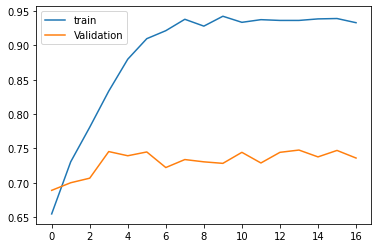

In [277]:
from matplotlib import pyplot

pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='Validation')
pyplot.legend()
pyplot.show()

#### Hyperparameter tuning by changing the validation split

In [278]:
BATCH_SIZE = 32
EPOCHS = 20
history = lstm_model_4.fit(X_attd_train_val, y_attd_train_val, validation_split=0.2, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, shuffle=True, callbacks=[stop, reduce_lr])

Epoch 1/20
91/91 [==============================] - 8s 91ms/step - loss: 0.9439 - accuracy: 0.8418 - val_loss: 1.3182 - val_accuracy: 0.7635
Epoch 2/20
91/91 [==============================] - 8s 91ms/step - loss: 0.8061 - accuracy: 0.8581 - val_loss: 1.2515 - val_accuracy: 0.7649
Epoch 3/20
91/91 [==============================] - 8s 91ms/step - loss: 0.7365 - accuracy: 0.8667 - val_loss: 1.2006 - val_accuracy: 0.7663
Epoch 4/20
91/91 [==============================] - 8s 91ms/step - loss: 0.6801 - accuracy: 0.8726 - val_loss: 1.2877 - val_accuracy: 0.7663
Epoch 5/20
91/91 [==============================] - 8s 91ms/step - loss: 0.6443 - accuracy: 0.8837 - val_loss: 1.1598 - val_accuracy: 0.7676
Epoch 6/20
91/91 [==============================] - 8s 92ms/step - loss: 0.6192 - accuracy: 0.8889 - val_loss: 1.1425 - val_accuracy: 0.7732
Epoch 7/20
91/91 [==============================] - 8s 91ms/step - loss: 0.6067 - accuracy: 0.8896 - val_loss: 1.2295 - val_accuracy: 0.7718
Epoch 8/20
91

In [279]:
loss, accuracy = lstm_model_4.evaluate(X_attd_test, y_attd_test)
print('Accuracy: %f' % (accuracy*100))
print('loss: %f' % (loss))

49/49 [==============================] - 1s 11ms/step - loss: 1.4020 - accuracy: 0.7578
Accuracy: 75.775194
loss: 1.402029


- Although the training data has overfit, but still the validation and test accuracy has increased considerably
- The validation accuracy has gone down to 78.01% and loss has increased to 124%  
- The test accuracy has increased to 75.78% as compared to attention layer model
- On the other hand, the loss has reduced to 140.20%, which is high as compared to attention models

In [212]:
incident = ['job printer printer issue']
#['login issue verify user detail employee']
#vectorizing the tweet by the pre-fitted tokenizer instance
inc = tokenizer.texts_to_sequences(incident)
#padding the tweet to have exactly the same shape as `embedding_2` input
#twt = pad_sequences(inc, maxlen=28, dtype='int32', value=0)
inc = sequence.pad_sequences(inc, maxlen=50)
print(inc)
sentiment = lstm_model_4.predict(inc,batch_size=1,verbose = 2)
print(sentiment)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 56 38
  38 11]]
1/1 - 0s
[[0.97194606 0.00216034 0.00175424 0.00179068 0.00553611 0.00377704
  0.0024497  0.00251492 0.00322086 0.00269284 0.00215725]]


ValueError: ignored